# Import

In [1]:
library(tidyverse)
library(leaps) # Subset selection
library(glmnet) # Ridge/Lasso
library(gam)
library(tree)
# library(splines)

df = read.csv("./data/listings.csv")
cleaned_df = df %>%
    select(-listing_url,-scrape_id,-last_scraped,-source,-name,-description,-neighborhood_overview,-picture_url,-host_id,-host_url,-host_name, -host_location,
    -host_about,-host_thumbnail_url,-host_picture_url,-host_neighbourhood,-host_verifications,-neighbourhood_group_cleansed,-bedrooms,-amenities,-calendar_updated,-calendar_last_scraped,-license) %>%
    mutate(price = as.numeric(str_remove(price, "\\$"))) %>%
    mutate(bathrooms = as.numeric(str_extract(bathrooms_text, "\\d+"))) %>%
    filter(room_type == "Entire home/apt")

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: splines

Loading required package: foreach


Attaching package: 'foreach'


The following objects are masked from 'package:purrr':

    accumulate, when


Loaded gam 1.22-3


Warning message:
"There was 1 warning in `mutate()`.
i In argument: `price = as.numeric(str_remove(price, 

In [2]:
cleaned_df = cleaned_df %>% dplyr::select(host_has_profile_pic, host_identity_verified, longitude, latitude, accommodates, bathrooms, beds, price, number_of_reviews, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, instant_bookable, reviews_per_month)
cleaned_df = na.omit(cleaned_df)
head(cleaned_df)
nrow(cleaned_df)

,host_has_profile_pic,host_identity_verified,longitude,latitude,accommodates,bathrooms,beds,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,t,t,-77.04008,38.91887,3,1,1,60,96,4.50,4.71,4.13,4.82,4.82,4.91,4.44,f,0.55
2,t,t,-77.09774,38.91999,2,1,2,66,91,4.79,4.77,4.87,4.94,4.90,4.79,4.81,f,0.54
3,t,t,-77.07591,38.92622,4,1,3,85,412,4.59,4.65,4.60,4.86,4.88,4.83,4.59,f,2.43
4,t,t,-77.03136,38.92836,2,1,2,125,38,4.84,4.92,4.84,5.00,4.97,4.76,4.84,f,0.23
5,t,t,-76.99133,38.90053,4,1,3,645,13,4.77,4.50,4.25,4.75,4.75,5.00,4.75,f,0.08
6,t,t,-77.00645,38.96650,1,1,1,65,11,5.00,4.60,4.80,5.00,5.00,4.20,4.40,f,0.07


[1] 3686

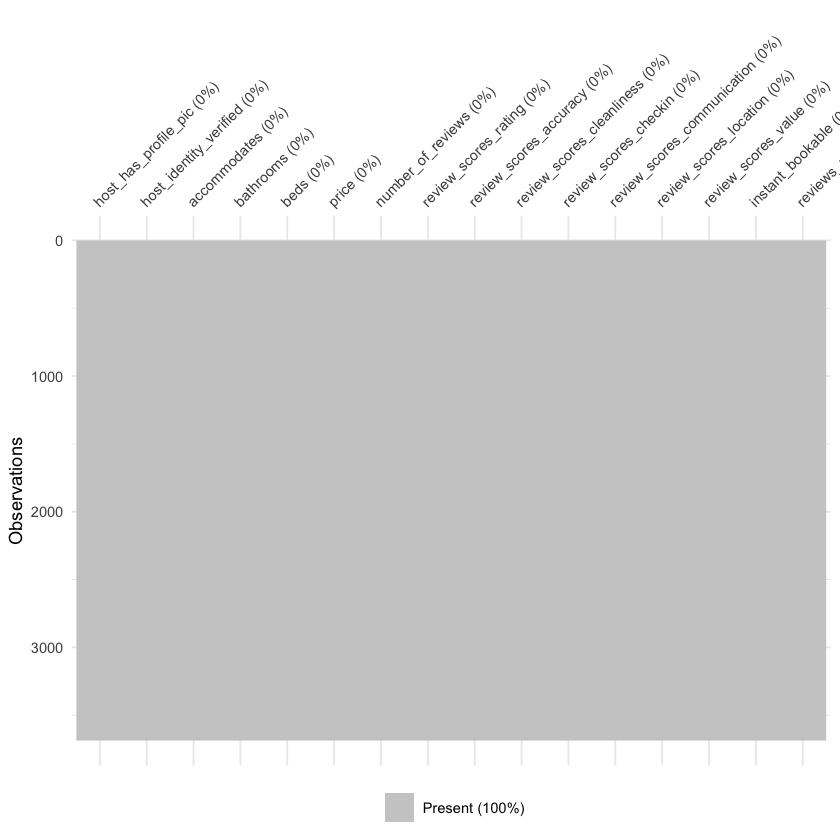

In [81]:
library(naniar)
vis_miss(cleaned_df)

In [3]:
indices = sample(nrow(cleaned_df), size = nrow(cleaned_df)*0.8, replace = FALSE)
train = cleaned_df[indices,]
test = cleaned_df[-indices,]

# Subset Selection

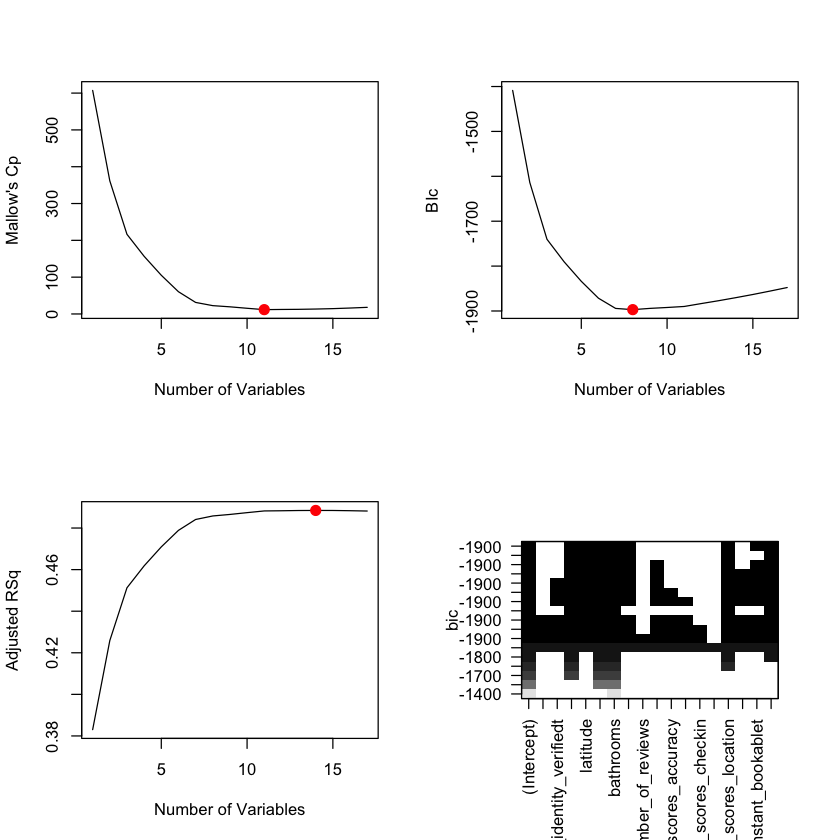

In [4]:
regfit.best = regsubsets(price~.,train, nvmax = ncol(train))
reg.summary=summary(regfit.best)

par(mfrow=c(2,2))
plot(reg.summary$cp,xlab="Number of Variables",ylab="Mallow's Cp",type="l")
points(which.min(reg.summary$cp),reg.summary$cp[which.min(reg.summary$cp)],col="red",cex=2,pch=20)

plot(reg.summary$bic,xlab="Number of Variables",ylab="BIc",type="l")
points(which.min(reg.summary$bic),reg.summary$bic[which.min(reg.summary$bic)],col="red",cex=2,pch=20)

plot(reg.summary$adjr2,xlab="Number of Variables",ylab="Adjusted RSq",type="l")
points(which.max(reg.summary$adjr2),reg.summary$adjr2[which.max(reg.summary$adjr2)],col="red",cex=2,pch=20)

plot(regfit.best,scale="bic")

In [5]:
paste("Number of variables in best model based on Cp: ", which.min(summary(regfit.best)$cp))
paste("Number of variables in best model based on BIC: ", which.min(summary(regfit.best)$bic))
paste("Number of variables in best model based on Adjusted R2: ", which.max(summary(regfit.best)$adjr2))

[1] "Number of variables in best model based on Cp:  11"

[1] "Number of variables in best model based on BIC:  8"

[1] "Number of variables in best model based on Adjusted R2:  14"

In [6]:
print(coef(regfit.best, 8))

           (Intercept)              longitude               latitude 
         -28847.175974            -616.042648            -481.506698 
          accommodates              bathrooms                   beds 
             11.575467              60.418315              11.175375 
review_scores_location      instant_bookablet      reviews_per_month 
             33.968956             -10.954117              -5.376385 


# Ridge regression / LASSO

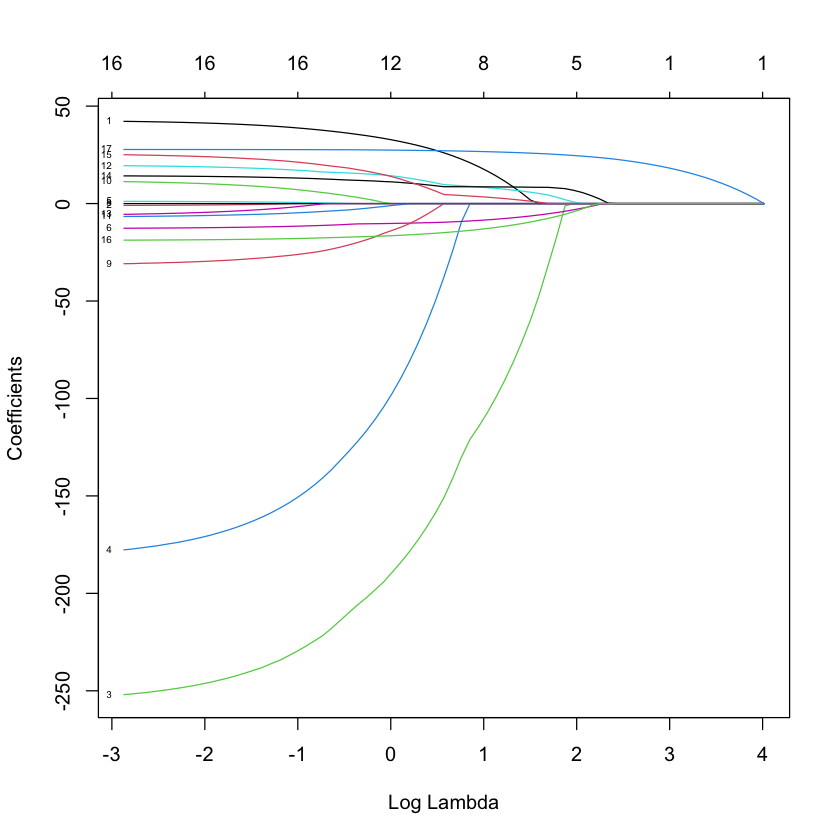

[1] "Test RMSE:  86.15791420315"

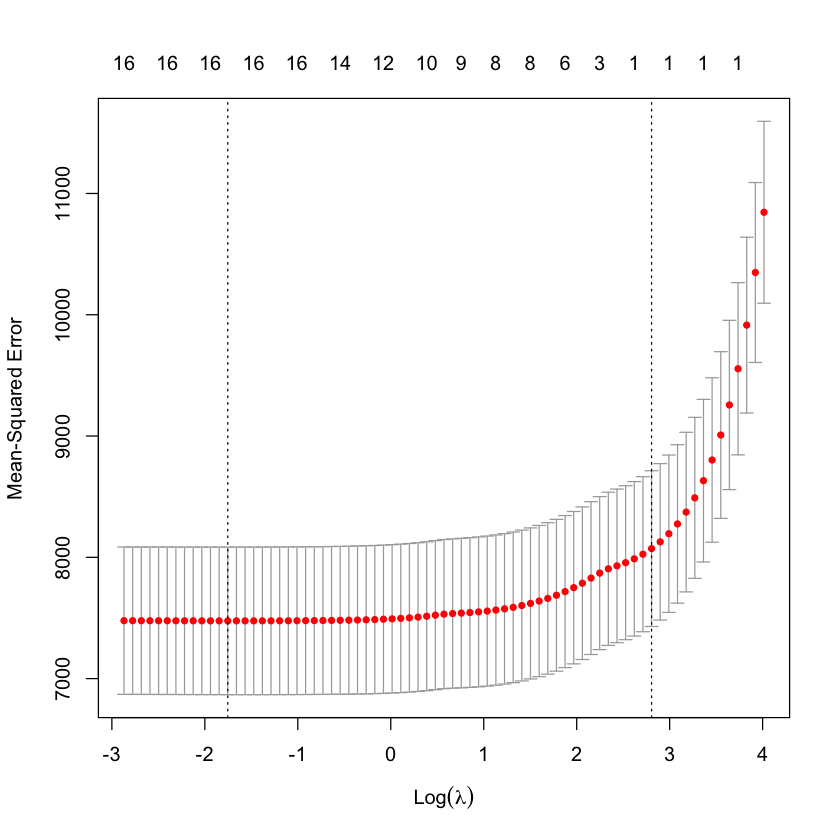

In [7]:
x = model.matrix(number_of_reviews ~ .,train)[,-1]
y = train$number_of_reviews

lasso.fit = glmnet(x, y, alpha = 1)
# ridge.fit = glmnet(x, y, alpha = 0)

plot(lasso.fit, xvar="lambda", label = TRUE)
# plot(ridge.fit, xvar="lambda", label = TRUE)

cv.lasso.fit = cv.glmnet(x, y, alpha = 1, nfolds = 10)
plot(cv.lasso.fit)
y_pred = predict.glmnet(lasso.fit, s = cv.lasso.fit$lambda.min, newx = x)
error = sqrt(mean((y_pred-y)**2))
paste("Test RMSE: ",error)

# Linear Regression

In [9]:
# lin.fit = glm(price ~ ., data = train)
# lin.fit2 = glm(price ~ .-price+bathrooms*reviews_per_month, data = train)
# lin.fit3 = glm(price ~ .+price*bathrooms+bathrooms*reviews_per_month, data = train)

lin.fit = lm(price ~ ., data = train)
lin.fit2 = lm(price ~ .+bathrooms*reviews_per_month, data = train)
lin.fit3 = lm(price ~ .+price*bathrooms+bathrooms*reviews_per_month, data = train)

stargazer::stargazer(lin.fit, lin.fit2,lin.fit3,type="text")
summary(lin.fit)

# par(mfrow=c(2,2))
# plot(lin.fit)

Warning message in model.matrix.default(mt, mf, contrasts):
"the response appeared on the right-hand side and was dropped"
Warning message in model.matrix.default(mt, mf, contrasts):
"problem with term 18 in model.matrix: no columns are assigned"



                                                          Dependent variable:                               
                            --------------------------------------------------------------------------------
                                                                 price                                      
                                       (1)                        (2)                        (3)            
------------------------------------------------------------------------------------------------------------
host_has_profile_pict                 17.453                     16.913                     3.213           
                                     (14.775)                   (14.715)                   (9.403)          
                                                                                                            
host_identity_verifiedt             -11.413**                  -10.763**                    -3.857          
                  


Call:
lm(formula = price ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-274.04  -41.39   -8.54   25.08  745.89 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -2.959e+04  4.092e+03  -7.231 6.09e-13 ***
host_has_profile_pict        1.745e+01  1.477e+01   1.181  0.23758    
host_identity_verifiedt     -1.141e+01  4.599e+00  -2.482  0.01314 *  
longitude                   -6.239e+02  5.800e+01 -10.757  < 2e-16 ***
latitude                    -4.783e+02  6.897e+01  -6.934 5.00e-12 ***
accommodates                 1.177e+01  1.292e+00   9.113  < 2e-16 ***
bathrooms                    5.943e+01  3.216e+00  18.479  < 2e-16 ***
beds                         1.116e+01  2.037e+00   5.479 4.63e-08 ***
number_of_reviews           -1.046e-02  1.708e-02  -0.613  0.54012    
review_scores_rating         2.617e+01  9.550e+00   2.740  0.00618 ** 
review_scores_accuracy      -9.464e+00  8.144e+00  -1.162  0.2453

In [10]:
pred = predict(lin.fit, test)
mean(sqrt((test$price - pred)**2))

[1] 53.15817

# Splines / GAM


Call: gam(formula = price ~ s(bathrooms) + s(review_scores_rating) + 
    s(review_scores_checkin) + s(review_scores_location) + s(review_scores_value) + 
    s(reviews_per_month), data = train)
Deviance Residuals:
    Min      1Q  Median      3Q     Max 
-303.95  -43.67  -13.10   25.29  705.39 

(Dispersion Parameter for gaussian family taken to be 7087.772)

    Null Deviance: 36755638 on 2947 degrees of freedom
Residual Deviance: 20717555 on 2923 degrees of freedom
AIC: 34530.3 

Number of Local Scoring Iterations: NA 

Anova for Parametric Effects
                            Df   Sum Sq  Mean Sq   F value    Pr(>F)    
s(bathrooms)                 1 14276702 14276702 2014.2723 < 2.2e-16 ***
s(review_scores_rating)      1   308809   308809   43.5693 4.841e-11 ***
s(review_scores_checkin)     1      680      680    0.0960    0.7567    
s(review_scores_location)    1   273768   273768   38.6254 5.865e-10 ***
s(review_scores_value)       1    18668    18668    2.6338    0.1047    
s(r

[1] 56.15274

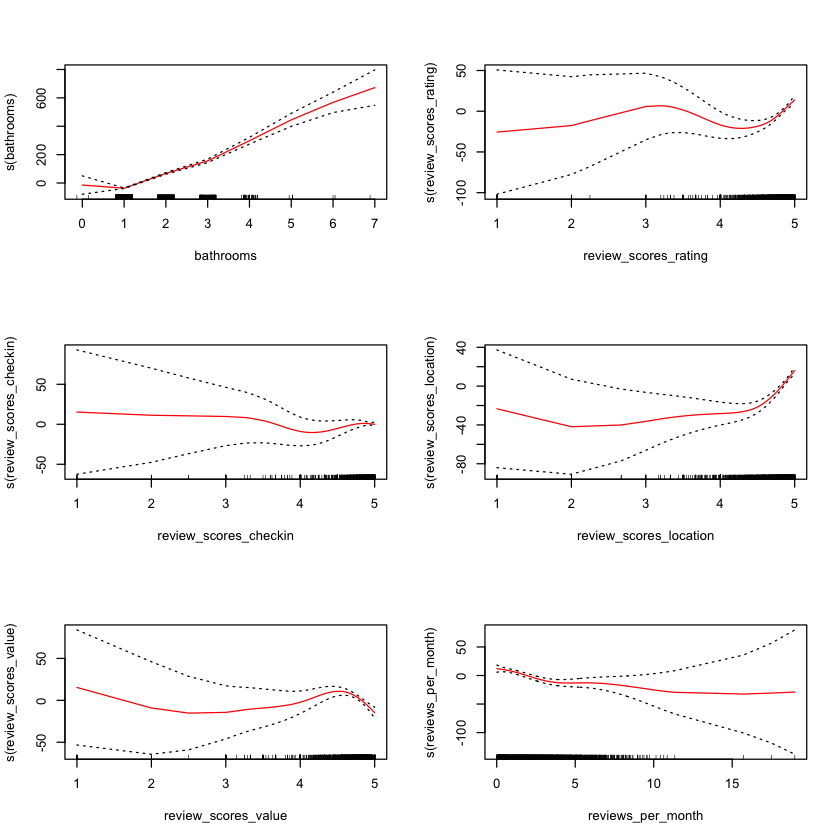

In [14]:
gam.fit = gam(price ~ s(bathrooms) + s(review_scores_rating) + s(review_scores_checkin) + s(review_scores_location) + s(review_scores_value) + s(reviews_per_month), data = train)
summary(gam.fit)
par(mfrow=c(3,2))
plot(gam.fit,  se=TRUE, col="red")

pred = predict(gam.fit, test)
mean(sqrt((test$price - pred)**2))

# Regression Tree

In [15]:
tree.fit = tree(price ~ ., data = train)
summary(tree.fit)

pred = predict(tree.fit, test)
mean(sqrt((test$price - pred)**2))

Warning message in tree(price ~ ., data = train):
"NAs introduced by coercion"



Regression tree:
tree(formula = price ~ ., data = train)
Variables actually used in tree construction:
[1] "bathrooms"            "accommodates"         "beds"                
[4] "review_scores_rating" "number_of_reviews"   
Number of terminal nodes:  8 
Residual mean deviance:  6753 = 19850000 / 2940 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-330.50  -41.33  -13.33    0.00   26.67  730.70 

Warning message in pred1.tree(object, tree.matrix(newdata)):
"NAs introduced by coercion"


[1] 55.58863

# Calendar data

In [90]:
calendar = read.csv("./data/calendar-3.csv")
calendar = calendar %>%
     filter(listing_id %in% df$id) %>%
     mutate(price = as.numeric(str_remove(price, "\\$"))) %>%
     mutate(adjusted_price = as.numeric(str_remove(adjusted_price, "\\$"))) %>%
     mutate(date = as.Date(date))
head(calendar)
nrow(calendar)

Warning message:
"There was 1 warning in `mutate()`.
i In argument: `price = as.numeric(str_remove(price, "\\$"))`.
Caused by warning:
! NAs introduced by coercion"
Warning message:
"There was 1 warning in `mutate()`.
i In argument: `adjusted_price = as.numeric(str_remove(adjusted_price,
  "\\$"))`.
Caused by warning:
! NAs introduced by coercion"


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
,<dbl>,<date>,<chr>,<dbl>,<dbl>,<int>,<int>
1,3686,2023-06-18,f,67,67,31,365
2,3686,2023-06-19,f,67,67,31,365
3,3686,2023-06-20,f,67,67,31,365
4,3686,2023-06-21,f,67,67,31,365
5,3686,2023-06-22,f,67,67,31,365
6,3686,2023-06-23,f,67,67,31,365


[1] 2025020

In [91]:
# filter where there is more than one distinct price
a = calendar %>%
    filter(!is.na(price)) %>%
    group_by(listing_id) %>%
    filter(n_distinct(price) > 1)

# Get the most common price value for each listing
b = a %>%
    group_by(listing_id, price) %>%
    summarise(count = n()) %>%
    filter(count == max(count)) 

`summarise()` has grouped output by 'listing_id'. You can override using the
`.groups` argument.


In [71]:
a %>%
    group_by(listing_id, price) %>%
    summarise(count = n()) %>%
    filter(listing_id == 883653)

`summarise()` has grouped output by 'listing_id'. You can override using the
`.groups` argument.


listing_id,price,count
<dbl>,<dbl>,<int>
883653,350,110
883653,351,2
883653,353,1
883653,355,1
883653,356,1
883653,357,1
883653,358,4
883653,359,6
883653,361,2


In [92]:
# Get rows where the price is different from the most common price
c = left_join(a, b %>% select(listing_id, price), by = "listing_id")
d = c %>% filter(price.x != price.y)

Warning message in left_join(a, b %>% select(listing_id, price), by = "listing_id"):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 27006 of `x` matches multiple rows in `y`.
i Row 33 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


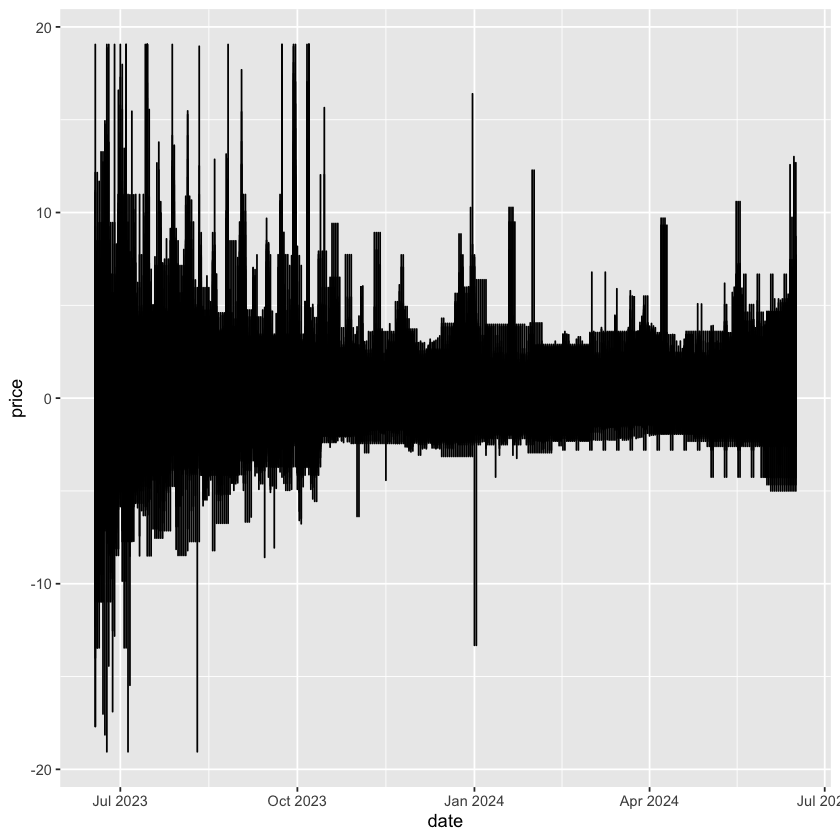

In [93]:
a %>%
    # filter(listing_id == 883653) %>%
    mutate(price = scale(price)) %>%
    group_by(listing_id) %>%
    ggplot(aes(x = date, y = price)) +
    geom_line()